# Impact on Digital Learning

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/fralfaro/portfolio/blob/main/docs/blog/posts/2021/basic-analysis-impact-on-digital-learning.ipynb)
[![](https://img.shields.io/static/v1?label=Kaggle&message=link&color=57aeac&labelColor=black&style=flat&logo=kaggle)](https://www.kaggle.com/code/faamds/basic-analysis-impact-on-digital-learning)


Main objective is understand of the best way the challenge [LearnPlatform COVID-19 Impact on Digital Learning](https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning/overview) proposed by [Kaggle](https://www.kaggle.com/).

The steps to follow are:

* **Overview of the Dataset**: Understanding the datasets available.
* **Preprocessing**: Preprocessing of the datasets available.
* **EDA**: Exploratory data analysis using visualization tools in Python.



> **Note**: My analysis is inspired by several of the notebooks that different profiles have uploaded to the challenge, so some graphics or images belong to these authors. The most important ones will be found in the references. On the other hand,  my project is available in [Jupyter Book](https://jupyterbook.org/intro.html), click in the following [link](https://faam.gitlab.io/learnplatform/learnplatform/index.html).

## Overview of the Dataset

The objective of this section is to be able to read and give an interpretation to each one of the available datasets, analyzing column by column. For each dataset we will make a brief description:

* **File**: File name (`.csv`).
* **Shape**: Dimensionality of datasets.
* **Description**: Basic description of the dataset.
* **Top 5 rows**: Show first 5 rows + explanation for some columns.
* **Summary**: Summary of datasets.

In [1]:
# libraries
import glob
import re


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')


# read data

## products dataset
path = '../input/learnplatform-covid19-impact-on-digital-learning/'
products_df = pd.read_csv(path + "products_info.csv")
products_df.columns = [x.lower().replace(' ','_') for x in products_df.columns]

## districts dataset
districts_df = pd.read_csv(path +"districts_info.csv")
#districts_df.state = districts_df.state.replace('District Of Columbia','District of Columbia')

## engagement dataset
path = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[-1].split(".")[0]
    df["district_id"] = district_id
    li.append(df)
engagement_df = pd.concat(li)
engagement_df = engagement_df.reset_index(drop=True)

# summary

df_list = [
    districts_df,
    products_df,
    engagement_df
]

df_name = [
    'districts_df',
    'products_df',
    'engagement_df'
]

cols = [
    'dataframe',
    'column', 
    'dtype', 
    'Non-Null Count', 
    'Null Count',
    'unique'
    
]

frames=[]


for i in range(len(df_list)):
    df = df_list[i].copy()
    a = df.dtypes.reset_index().rename(columns = {'index':'column',0:'dtype'})
    b = df.count().reset_index().rename(columns = {'index':'column',0:'Non-Null Count'})
    c = df.isnull().sum().reset_index().rename(columns = {'index':'column',0:'Null Count'})
    temp = a.merge(b,on = 'column').merge(c,on = 'column')
    
    dct = {col: len(df[col].unique()) for col in df.columns}
    df_unique = pd.DataFrame({
    'column':dct.keys(),
    'unique':dct.values(),
    })
    temp = temp.merge(df_unique,on = 'column')
    temp['dataframe'] = df_name[i]
    frames.append(temp)

### 1.  Districts

* **File**: `districts_info.csv`.
* **Shape**: $233$ rows $\times$  $7$ columns.
* **Description**: file contains information about each school district.
* **Top 5 rows:**:

<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/districts.png"  class="center" >

* **Summary**:

<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/1.png" width="400" height="200" alt="centered image" >

### 2. Products

* **File**: `products_info.csv`
* **Shape**: $372$ rows $\times$  $6$ columns.
* **Description**: for each school district, there is an additional file that contains the engagement for each tool for everyday in 2020. 
* **Top 5 rows:**:
<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/products.png" >

* **Summary**:

<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/2.png"  width="400" height="200" alt="centered image" >

### 3. Engagement
* **File**: `engagement_data/*.csv`.
* **Shape**: $22324190$ rows $\times$  $5$ columns.
* **Description**: file contains information about each school district. The files can be joined by the key columns `district_id` and `lp_id`.
* **Top 5 rows:**:
<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/engagement.png">

* **Summary**:

<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/3.png"  width="400" height="200" alt="centered image">

## Preprocessing

Preprocessing is an important step in any analytics competition. It helps you to handle your data more efficiently. However, please note that the way I preprocess the data may not be suited for your analysis purposes. Therefore, before you begin preprocessing your data, think about which data you would like to keep and/or modify and which data is not relevant for your analysis.

* one-hot encoding the product sectors
* splitting up the primary essential function into main and sub category

> **Note**: Preprocessing varies if you see other notebooks of this challenge.
The processing will depend on the understanding of each of the datasets and the extra information that you may have.

<img src="https://gitlab.com/FAAM/learnplatform/-/raw/master/images/4.png" >

In [2]:
# products_df

products_df['primary_function_main'] = products_df['primary_essential_function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
products_df['primary_function_sub'] = products_df['primary_essential_function'].apply(lambda x: x.split(' - ')[1] if x == x else x)

# Synchronize similar values
products_df['primary_function_sub'] = products_df['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'})
#products_df.drop("Primary Essential Function", axis=1, inplace=True)

temp_sectors = products_df['sector(s)'].str.get_dummies(sep="; ")
temp_sectors.columns = [f"sector_{re.sub(' ', '', c)}" for c in temp_sectors.columns]
products_df = products_df.join(temp_sectors)
#products_df.drop("Sector(s)", axis=1, inplace=True)

#del temp_sectors

# engagement_df

engagement_df['time'] = pd.to_datetime(engagement_df['time'])

temp = engagement_df[['time']].drop_duplicates('time')
temp['week'] = temp['time'].apply(lambda x: x.isocalendar()[1])
engagement_df = engagement_df.merge(temp,on ='time')

engagement_df['lp_id'] = engagement_df['lp_id'].fillna(-1).astype(int)
engagement_df['district_id'] = engagement_df['district_id'].fillna(-1).astype(int)

engagement_df_mix = engagement_df.merge(
    districts_df[['district_id','state']],
    on = 'district_id'
)
engagement_df_mix = engagement_df_mix.merge(
    products_df[['lp_id','product_name','sector_Corporate', 'sector_HigherEd','sector_PreK-12']],
    on = 'lp_id'
)

## EDA
Exploratory data analysis is the most important part of the challenge, since this will make the difference between the winner and the other participants. You should keep in mind that your visualizations must be able to simply and easily summarize the datasets. Also, it is hoped that the proposed visualizations can help to understand behaviors that are not easy to analyze with a simple table.

Visualizations will be made in [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) y [plotly](https://plotly.com/python/). Based on the article by [*Diverging Color Maps for Scientific Visualization (Expanded) - Kenneth Moreland*](https://www.kennethmoreland.com/color-maps/ColorMapsExpanded.pdf), we will occupy `Grays` scale  next to the technique: dark text on a light background.


> **Note**: Visualizations made on this notebook are static. You can use different tools to be able to make dynamic visualizations ([Altair](https://altair-viz.github.io/), [plotly](https://plotly.com/python/), etc.). You can also perform tools like [Streamlit](https://streamlit.io/) to make Dashboards. On the other hand, if you fully understand python visualization tools and have knowledge of HTML/CSS, you can make beautiful notebook presentations like [this one](https://www.kaggle.com/spitfire2nd/enthusiast-to-data-professional-what-changes).

### Visualization: Districts

First of all, I am interested how diverse the available school districts are. As you can see in below plot, the available data does not cover all the states in the U.S. . The states with the most available school districts are CT (30) and UT (29) while there are also states with only one school district (FL, TN, NY, AZ).


In [3]:
# map plot: districts

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

districts_df['state_abbrev'] = districts_df['state'].replace(us_state_abbrev)
districts_info_by_state = districts_df['state_abbrev'].value_counts().to_frame().reset_index(drop=False)
districts_info_by_state.columns = ['state_abbrev', 'num_districts']

temp = pd.DataFrame({
    'state_abbrev':us_state_abbrev.values(),
})

temp = temp.merge(districts_info_by_state,on='state_abbrev',how='left').fillna(0)
temp['num_districts'] = temp['num_districts'].astype(int)

fig = go.Figure()
layout = dict(
    title_text = "Number of Available School Districts per State",
    title_font_color="black",
    geo_scope='usa',
)    


fig.add_trace(
    go.Choropleth(
        locations=temp.state_abbrev,
        zmax=1,
        z = temp.num_districts,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        marker_line_color='black',
        geo='geo',
        colorscale=px.colors.sequential.Greys, 
        
    )
)
            
fig.update_layout(layout)   
fig.show()

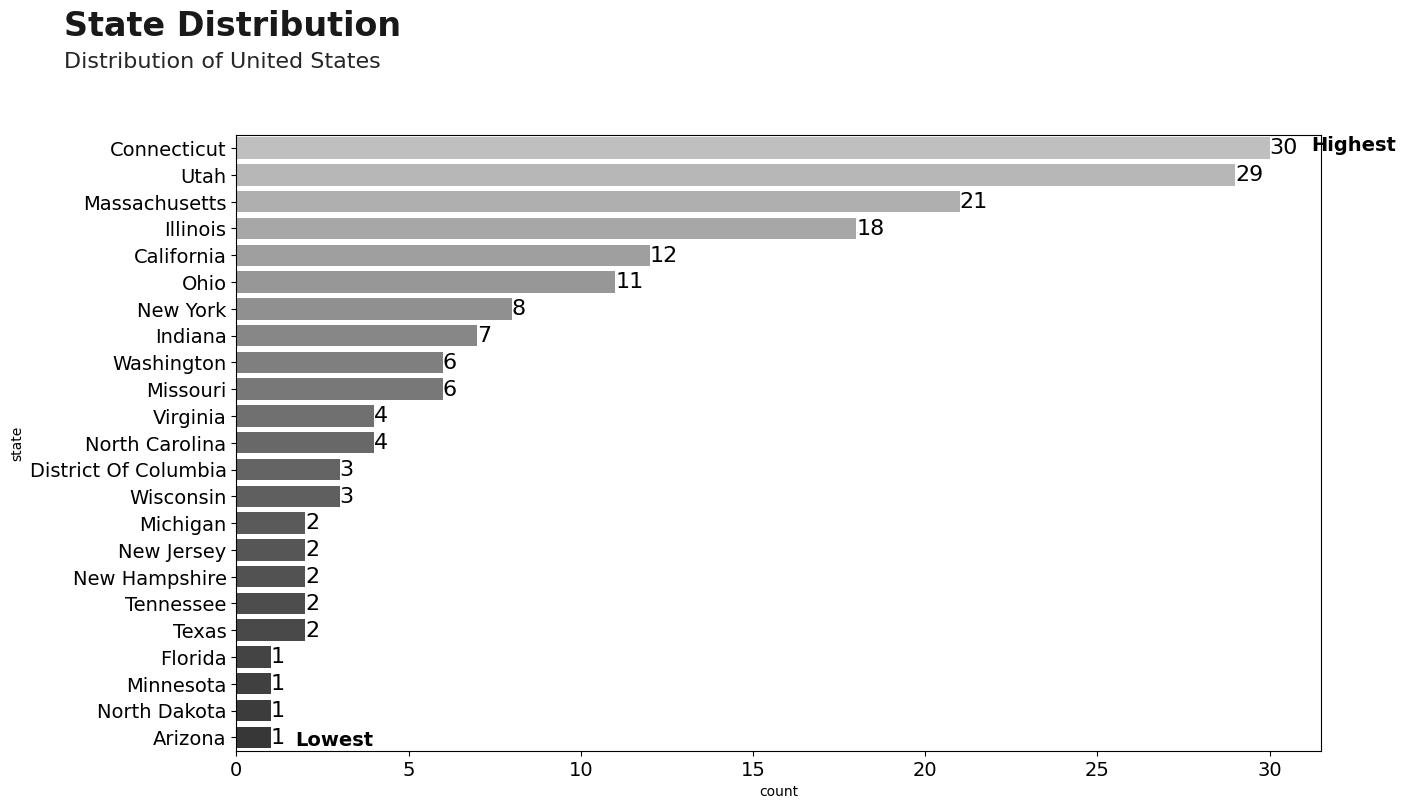

In [4]:
# bar plot: districts

plt.style.use('default')
plt.figure(figsize=(14,8))

plotting = sns.countplot(
    y="state",
    data=districts_df,
    order=districts_df.state.value_counts().index,
    palette="Greys_d",
    linewidth=3
)

for container in plotting.containers:
    plotting.bar_label(container,fontsize=16)

#Text
plotting.text(x = -5, y = -4.2, s = "State Distribution",fontsize = 24, weight = 'bold', alpha = .90);
plotting.text(x = -5, y = -3, s = "Distribution of United States",fontsize = 16, alpha = .85)
plotting.text(x = 31.2, y = 0.08, s = 'Highest', weight = 'bold',fontsize = 14)
plotting.text(x = 1.7, y = 22.3, s = 'Lowest', weight = 'bold',fontsize = 14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)



plt.show()

### Visualization: Locales

Locales are separated into 4 categories: **Suburb**,**Rural**, **City** and **Town**, where most of the locales are concentrated in the *Suburb* category (104).

For the `pct_black/hispanic` variable, *Rural* and *Town* categories concentrate their entire population close to the interval $ [0,0.2 [$, while for the others sectors this percentage is varied.

For `pctfree/reduced` and `pp_total_raw` indicators, the distribution for each location is different, although they tend to focus on a particular interval.


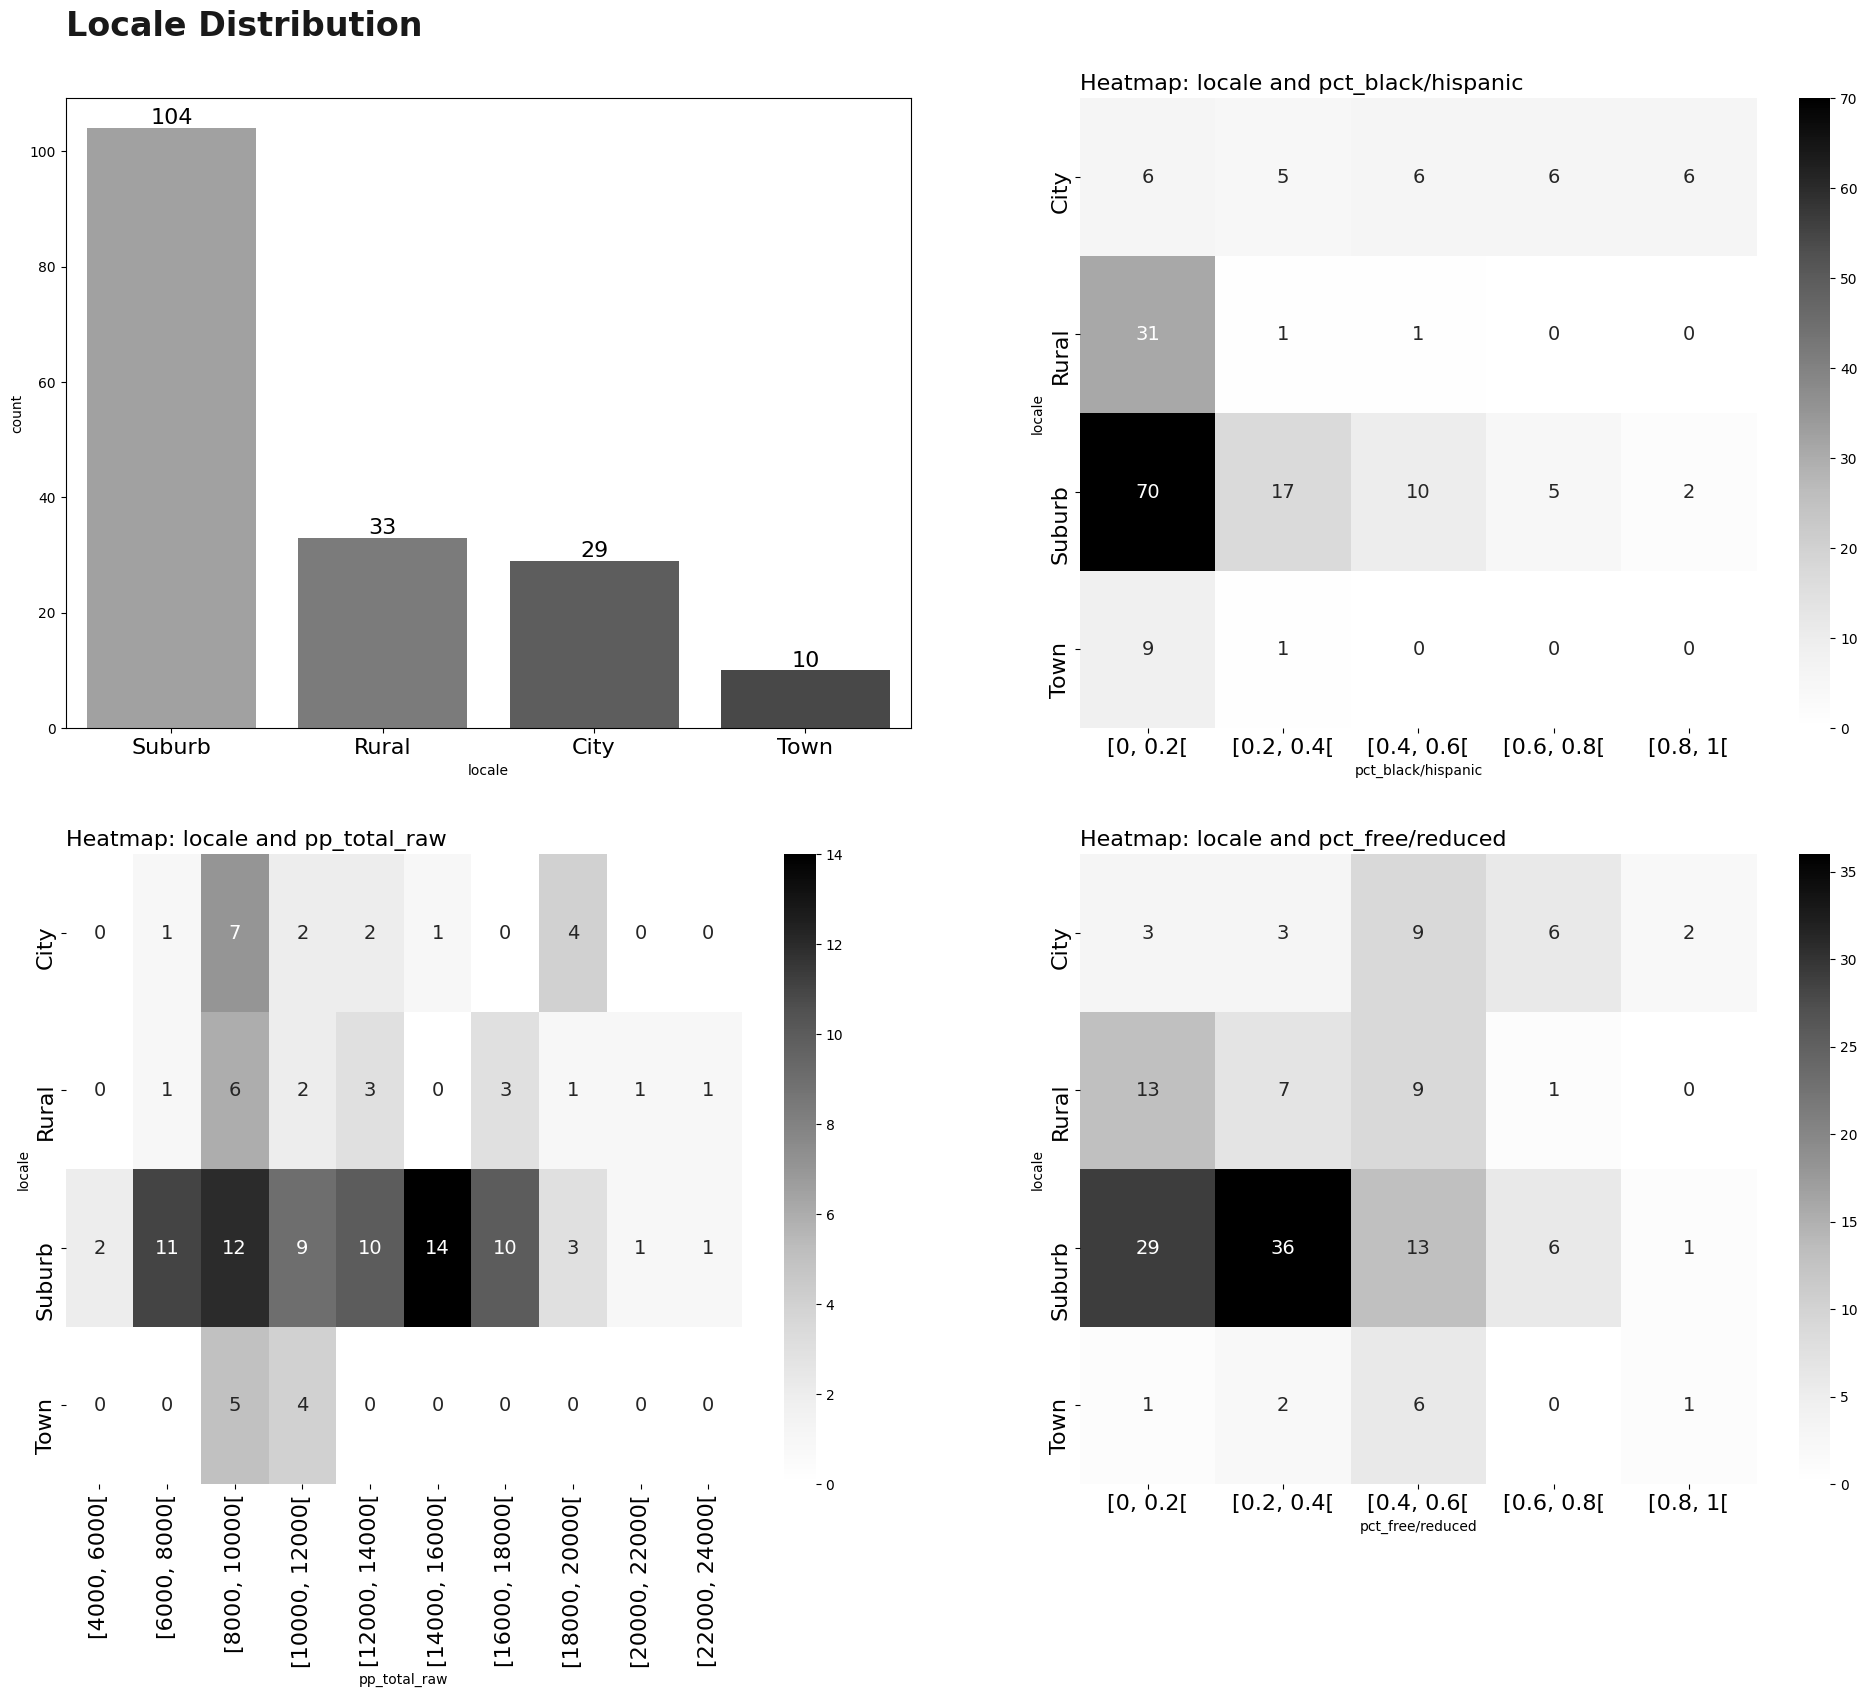

In [5]:
# heatmap: districts -> locale

temp = districts_df.groupby('locale').pp_total_raw.value_counts().to_frame()
temp.columns = ['amount']

temp = temp.reset_index(drop=False)

temp = temp.pivot(index='locale', columns='pp_total_raw')['amount']
temp = temp[['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ]]


temp1 = districts_df.groupby('locale')['pct_black/hispanic'].value_counts().to_frame()
temp1.columns = ['amount']

temp1 = temp1.reset_index(drop=False)
temp1 = temp1.pivot(index='locale', columns='pct_black/hispanic')['amount']

temp2 = districts_df.groupby('locale')['pct_free/reduced'].value_counts().to_frame()
temp2.columns = ['amount']

temp2 = temp2.reset_index(drop=False)

temp2 = temp2.pivot(index='locale', columns='pct_free/reduced')['amount']

plt.style.use('default')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(24,18))

sns.countplot(data=districts_df, x='locale', ax=ax1, palette='Greys_d')
ax1.text(x = -0.5, y = 120, s = "Locale Distribution",fontsize = 24, weight = 'bold', alpha = .90);
ax1.xaxis.set_tick_params(labelsize=16)

for container in ax1.containers:
    ax1.bar_label(container,fontsize=16)

sns.heatmap(temp1.fillna(0), annot=True,  cmap='Greys', ax=ax2,annot_kws={"fontsize":14})
ax2.set_title('Heatmap: locale and pct_black/hispanic',fontsize=16,loc='left')
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

sns.heatmap(temp.fillna(0), annot=True,  cmap='Greys', ax=ax3,annot_kws={"fontsize":14})
ax3.set_title('Heatmap: locale and pp_total_raw',fontsize=16,loc='left')
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

sns.heatmap(temp2.fillna(0), annot=True,  cmap='Greys', ax=ax4,annot_kws={"fontsize":14})
ax4.set_title('Heatmap: locale and pct_free/reduced',fontsize=16,loc='left')
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)


plt.show()

### Visualization: Sectors

Sectors are separated into 3 categories: **sector_Corporate**, **sector_HigherEd** and **sector_PreK-12**, donde la categoría mayoritaria corresponde a *sector_PreK-12* (350). On the other hand, analyzing the `primary_function_main` variable, all sectors are focused on the` LC` category. It is worth mentioning that the distribution of the other categories remains almost the same between sectors.

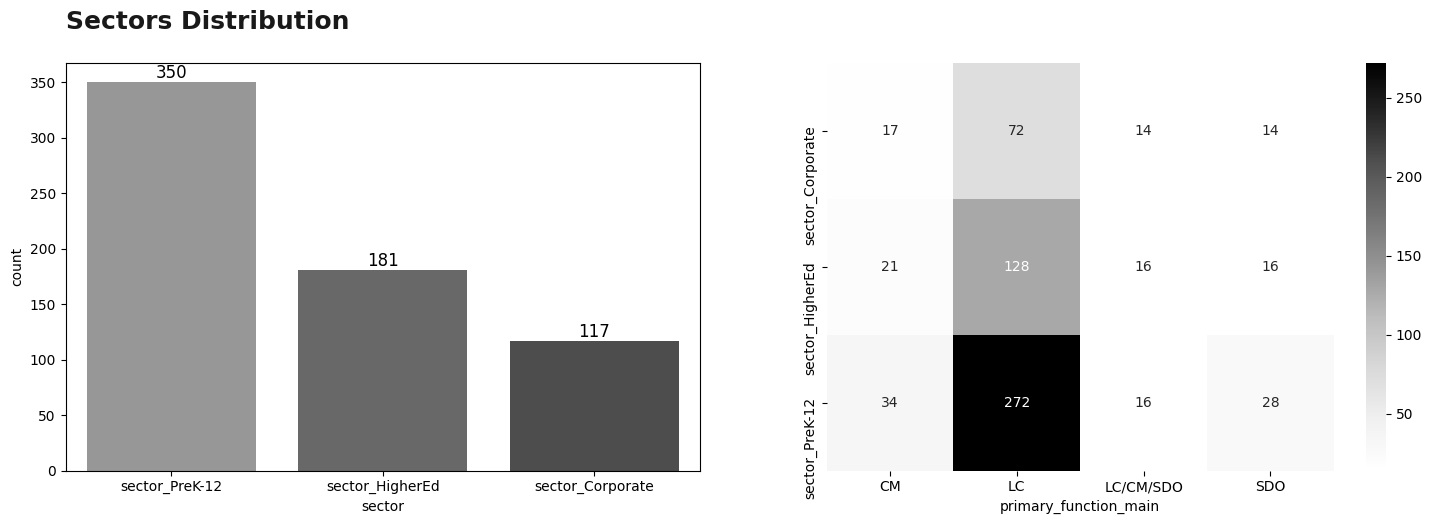

In [6]:
plt.style.use('default')
names = ['sector_Corporate', 'sector_HigherEd','sector_PreK-12']
counts = [products_df[x].sum() for x in names]

temp_bar = pd.DataFrame({
    'sector':names,
    'count':counts
}).sort_values('count',ascending = False)

temp = products_df.groupby('primary_function_main')[names].sum()

#fig, [ax1, ax2 ]= plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.figure(figsize=(18,18))

plt.subplot(3,2,1)
ax = sns.barplot(x="sector", y="count", data=temp_bar,palette ='Greys_d')
for container in ax.containers:
    ax.bar_label(container,fontsize=12)

plt.subplot(3,2,2)

sns.heatmap(temp.T, annot=True,  cmap='Greys',annot_kws={"fontsize":10},fmt='g')

plt.text(x = -6, y = -0.25, s = "Sectors Distribution",fontsize = 18, weight = 'bold', alpha = .90);

plt.show()

### Visualization:  primary_function_main

Continuing the analysis of the `primary_function_main` variable, it was observed that most of these are in the` LC` category (77%). Within this category, its subcategory is analyzed, where the predominant subcategory is `Sites, Resources & Reference` (101).

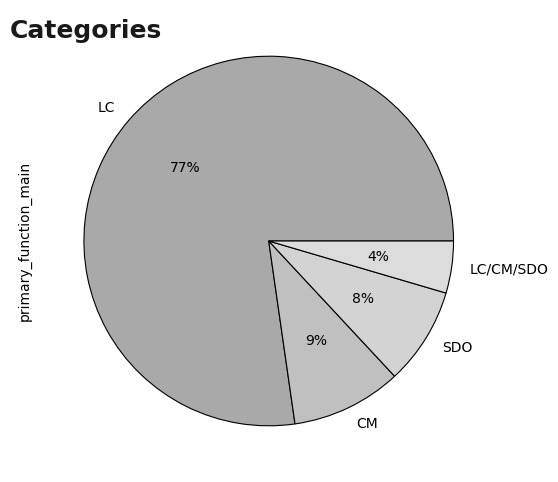

In [7]:
# pieplot: products

color = [
    'darkgray',
    'silver',
    'lightgray',
    'gainsboro',
]

products_df["primary_function_main"].value_counts().plot(
    kind = 'pie', 
    autopct='%1d%%', 
    figsize=(6,6), 
    colors=color,
    wedgeprops={"edgecolor":"k",'linewidth': 0.8,},
    textprops={'color':"black"},
    startangle=0)
plt.text(x = -1.4, y = 1.1, s = "Categories",fontsize = 18, weight = 'bold', alpha = .90);
plt.show()

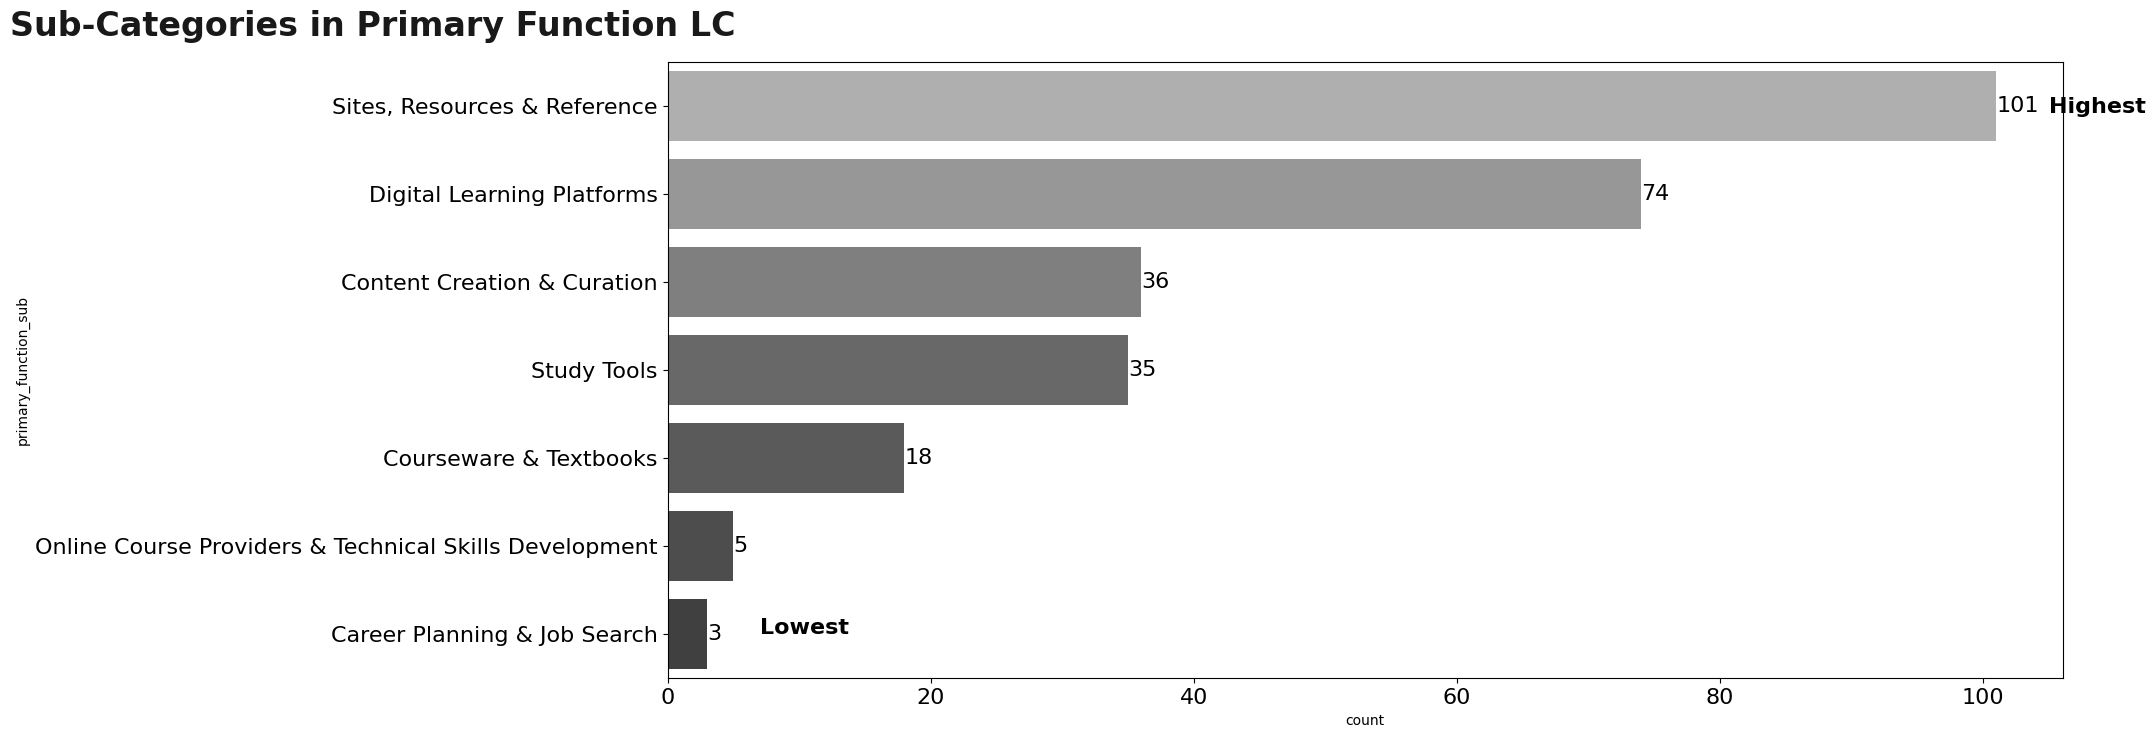

In [8]:
# pieplot: products -> subcategories

plt.style.use('default')
plt.figure(figsize=(18,8))

temp = products_df[products_df.primary_function_main == 'LC']
ax = sns.countplot(
    data=temp, 
    y='primary_function_sub',
    order=temp.primary_function_sub.value_counts().index,
    palette ='Greys_d'
)

for container in ax.containers:
    ax.bar_label(container,fontsize=16)


#plt.title('Sub-Categories in Primary Function LC')
plt.text(x = -50, y = -0.8, 
         s = "Sub-Categories in Primary Function LC",fontsize = 24, weight = 'bold', alpha = .90);

plt.text(x = 105, y =0.08, s = 'Highest', weight = 'bold',fontsize=16)
plt.text(x = 7, y = 6, s = 'Lowest', weight = 'bold',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

### Visualization: Products

After understanding the functionality of each of the tools, it is necessary to understand the distribution of the tools. The first thing is to study the distribution of the providers of the products we have, where:

* 258 providers have 1 occurrences.
* 18 providers have 2 occurrences.
* 9 providers have 3 occurrences.
* 2 providers have 4 occurrences.
* 2 providers have 6 occurrences.
* 1 provider have 30 occurrences.



Based on this, only the top 15 providers will be displayed.

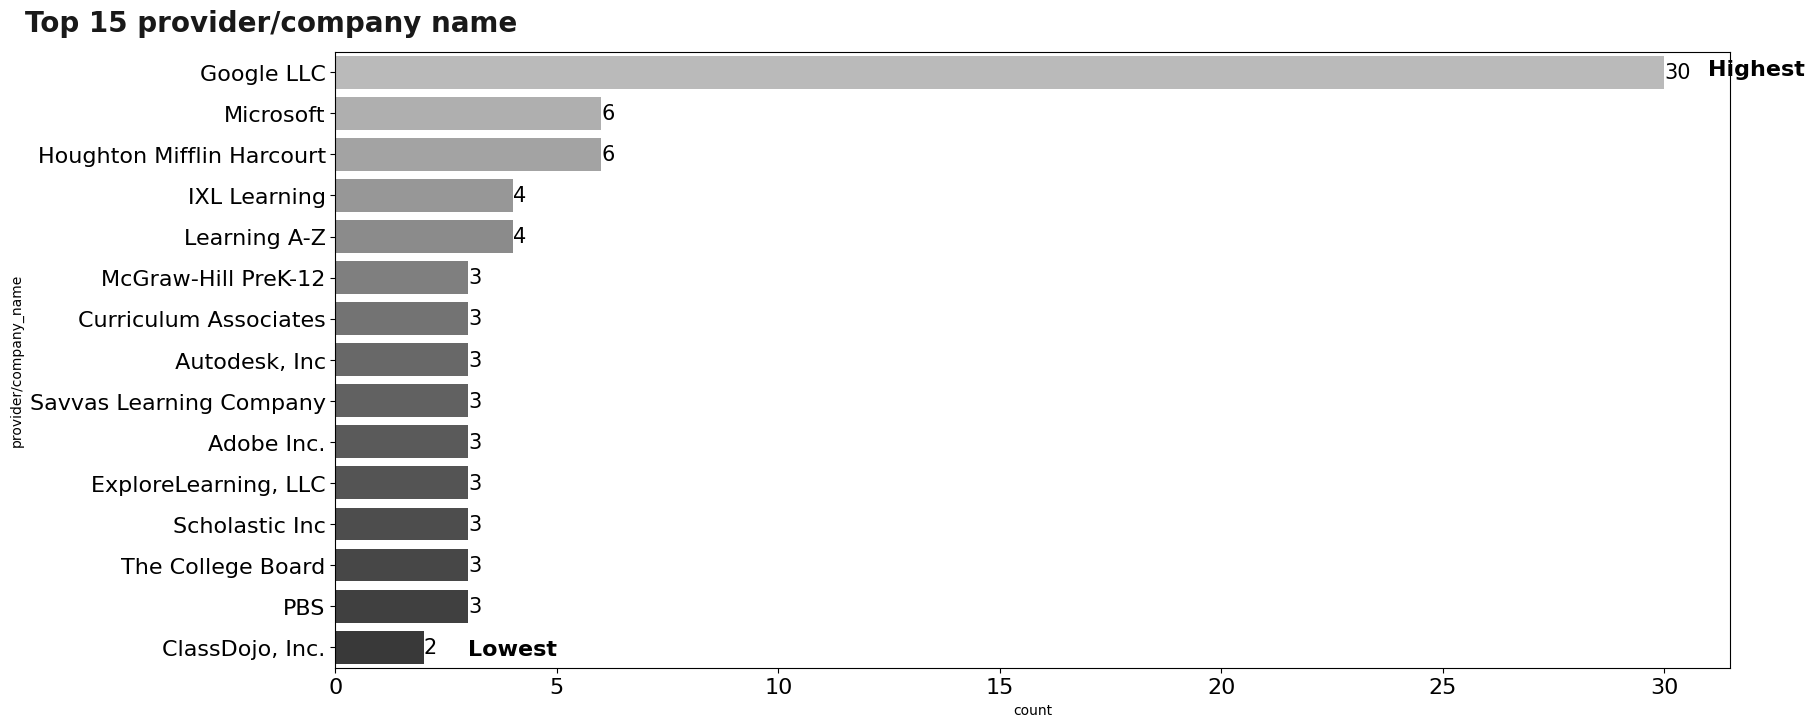

In [9]:
dct = {
    'Savvas Learning Company | Formerly Pearson K12 Learning': 'Savvas Learning Company'
}

temp = products_df['provider/company_name'].value_counts().reset_index()
temp.columns = ['provider/company_name','count']
temp = temp.replace( {
    'Savvas Learning Company | Formerly Pearson K12 Learning': 'Savvas Learning Company'
})

n = 15
temp = temp.sort_values('count',ascending = False).head(n)

plt.style.use('default')
plt.figure(figsize=(18,8))

ax = sns.barplot(
    data=temp, 
    y='provider/company_name',
    x='count',
    palette ='Greys_d'
)

for container in ax.containers:
    ax.bar_label(container,fontsize=15)
    
plt.text(x = -7, y = -1, 
         s = f"Top {n} provider/company name",fontsize = 20, weight = 'bold', alpha = .90);
   
plt.text(x = 31, y =0.08, s = 'Highest', weight = 'bold',fontsize=16)
plt.text(x = 3, y = 14.2, s = 'Lowest', weight = 'bold',fontsize=16)
plt.yticks(fontsize=16)


plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

With regard to products, there are about 372 different products.

We can make a word cloud to be able to analyze in a different way, words by themselves that are repeated the most in the `product_name` variable.

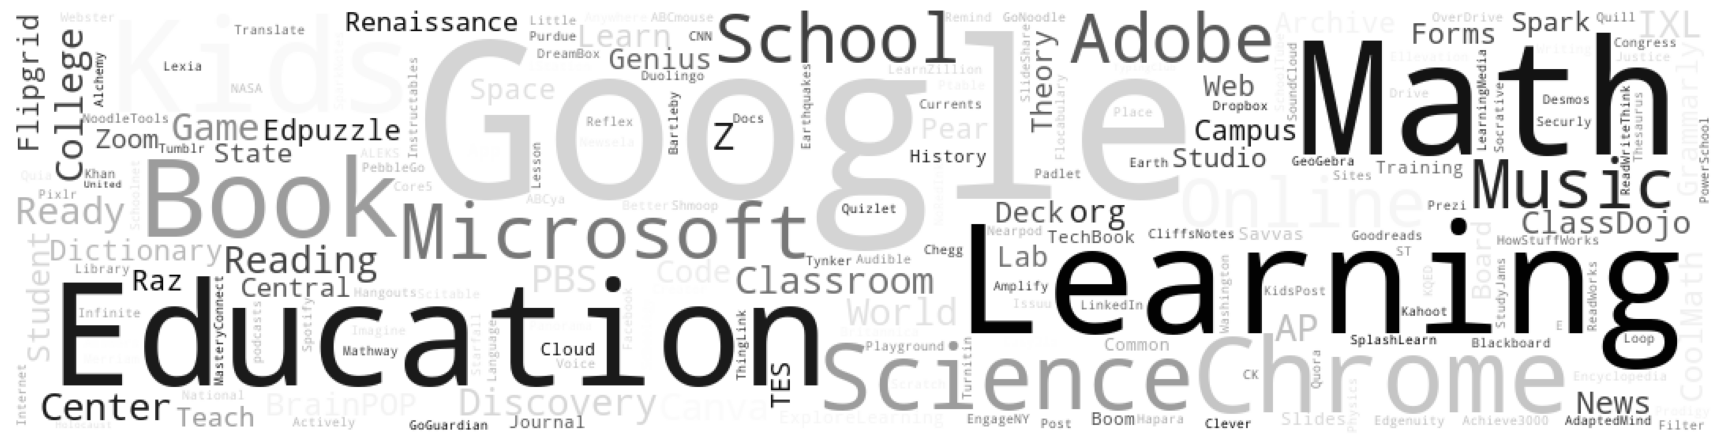

In [10]:
cloud = WordCloud(
    width=1080,
    height=270,
    colormap='Greys',
    background_color='white'
    ).generate(" ".join(products_df['product_name'].astype(str)))

plt.figure(figsize=(22, 10))
plt.imshow(cloud)
plt.axis('off');

To understand more in detail the use of these products, we will analyze the use of these products with respect to the variable `engagement_index`. The first graph is related to the average `engagement_index` (per student) for the year 2020, where the first 15 products will be displayed.

An important fact is that 362 products have an average of less than 1!.


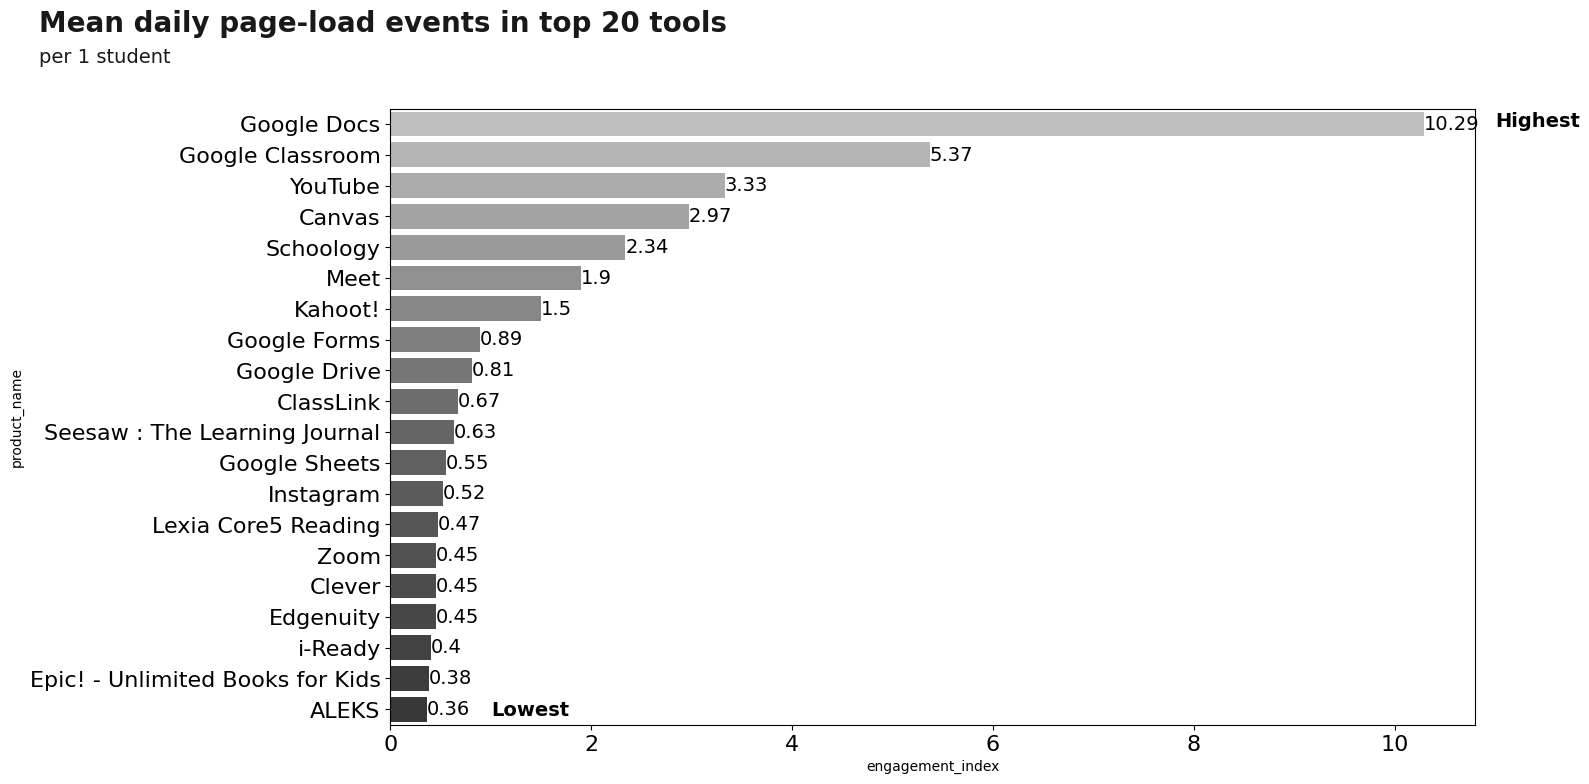

In [11]:
group_01 = (engagement_df_mix.groupby('product_name')['engagement_index'].mean()/1000).reset_index().sort_values('engagement_index',ascending = False)
group_01['engagement_index'] = group_01['engagement_index'].apply(lambda x: round(x,2))
less_1 = len(group_01.loc[lambda x:x['engagement_index']<1])


plt.style.use('default')
plt.figure(figsize=(14,8))

plotting = sns.barplot(
    y="product_name",
    x = "engagement_index",
    data=group_01.head(20),
    palette="Greys_d",

)

for container in plotting.containers:
    plotting.bar_label(container,fontsize=14)

plt.text(x = -3.5, y = -3, 
         s = "Mean daily page-load events in top 20 tools",fontsize = 20, weight = 'bold', alpha = .90);

plt.text(x = -3.5, y = -2, 
         s = "per 1 student",fontsize = 14,  alpha = .90);

plt.text(x = 11, y =0.1, s = 'Highest', weight = 'bold',fontsize=14)
plt.text(x = 1, y = 19.2, s = 'Lowest', weight = 'bold',fontsize=14)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()

Let's study the temporal behavior (at the level of weeks) of these tools during the year 2020, where the most  three used tools will be shown with different colors, while the other tools will be visualized but with the same color (in order to understand their distribution).

> **Note**: The proposed analysis can be carried out at the day level and analyzing through time series each of the tools during the year 2020.

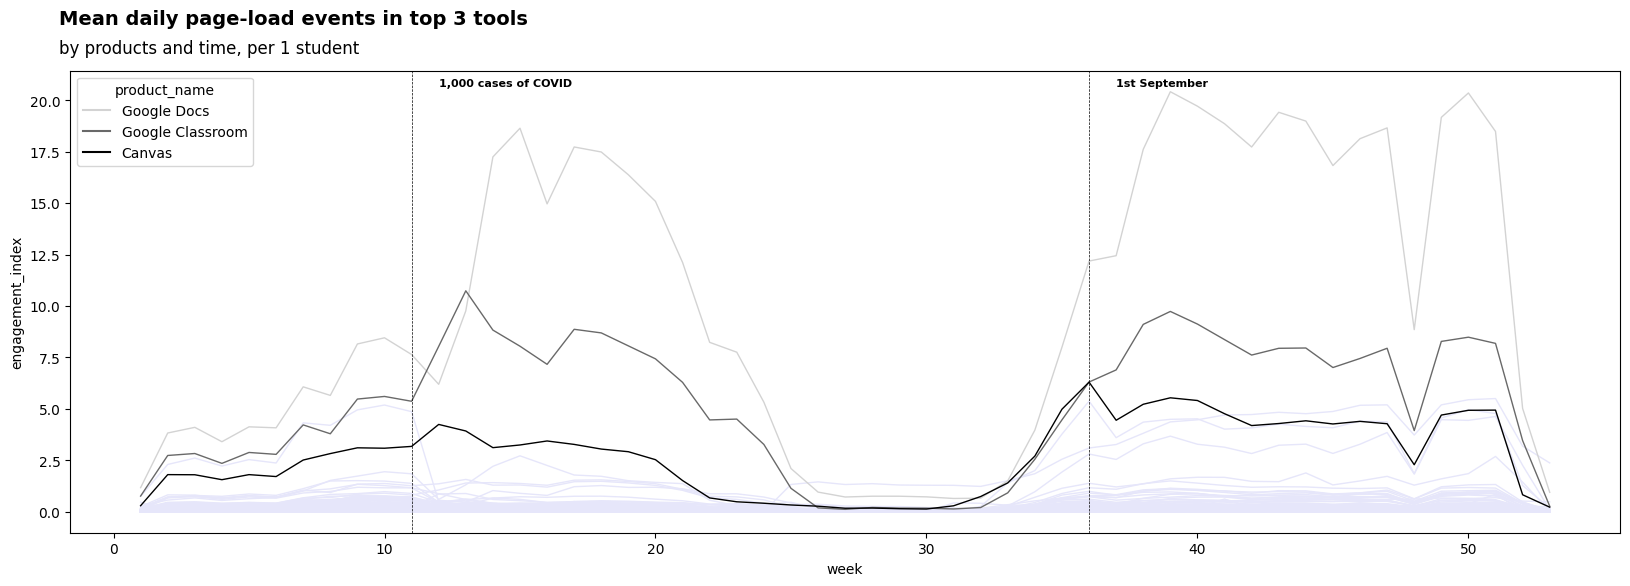

In [12]:
col = 'week'

group_04  = (engagement_df_mix.groupby(['product_name',col])['engagement_index'].mean()/1000).reset_index().sort_values('engagement_index',ascending = False)

g_high = group_01.head(3)['product_name']
group_04_top = group_04.loc[lambda x: x.product_name.isin(g_high)]

states = group_04['product_name'].unique()
times= group_04[col].unique()

index = pd.MultiIndex.from_product([states,times], names = ["product_name", col])

df_complete = pd.DataFrame(index = index).reset_index().fillna(0)

group_04 = df_complete.merge(group_04,on = ['product_name',col],how='left').fillna(0)

n = 3
g_high = group_04.groupby('product_name')['engagement_index'].sum().sort_values(ascending=False).head(n).index.to_list()


colors = [    
    'lightgray', 
    'dimgray', 
    'black', 
    'firebrick', 
    'darkred']
palette_01 = {x:'lavender' for x in group_04['product_name'].unique() if x not in g_high}
palette_02 = {g_high[i]:colors[i] for i in range(n)}

plt.style.use('default')
plt.figure(figsize=(20,6))


sns.lineplot(
    data=group_04.loc[lambda x: ~x.product_name.isin(g_high)], 
    x=col, 
    y="engagement_index", 
    hue='product_name',
    legend = False,
    palette=palette_01,
    linewidth = 1.

    )

sns.lineplot(
    data=group_04.loc[lambda x: x.product_name.isin(g_high)], 
    x=col, 
    y="engagement_index", 
    hue='product_name',
    palette=palette_02,
    linewidth = 1.

    )


plt.text(x = -2, y =23.7, s = 'Mean daily page-load events in top 3 tools', weight = 'bold',fontsize=14)
plt.text(x = -2, y =22.3, s = 'by products and time, per 1 student',fontsize=12)


plt.text(x = 12, y =20.7, s = '1,000 cases of COVID', weight = 'bold',fontsize=8)
plt.text(x = 37, y =20.7, s = '1st September', weight = 'bold',fontsize=8)


plt.axvline(x = 11, color = 'black', linestyle='--',linewidth = 0.5)
plt.axvline(x = 36, color = 'black', linestyle='--',linewidth = 0.5)
plt.show()

Now, we can understand the `engagement index` for the most important tools about districts, where the districts of * Wisconsin *, * Missouri * and * Virginia * have the highest `engagement index` among the three most used tools.

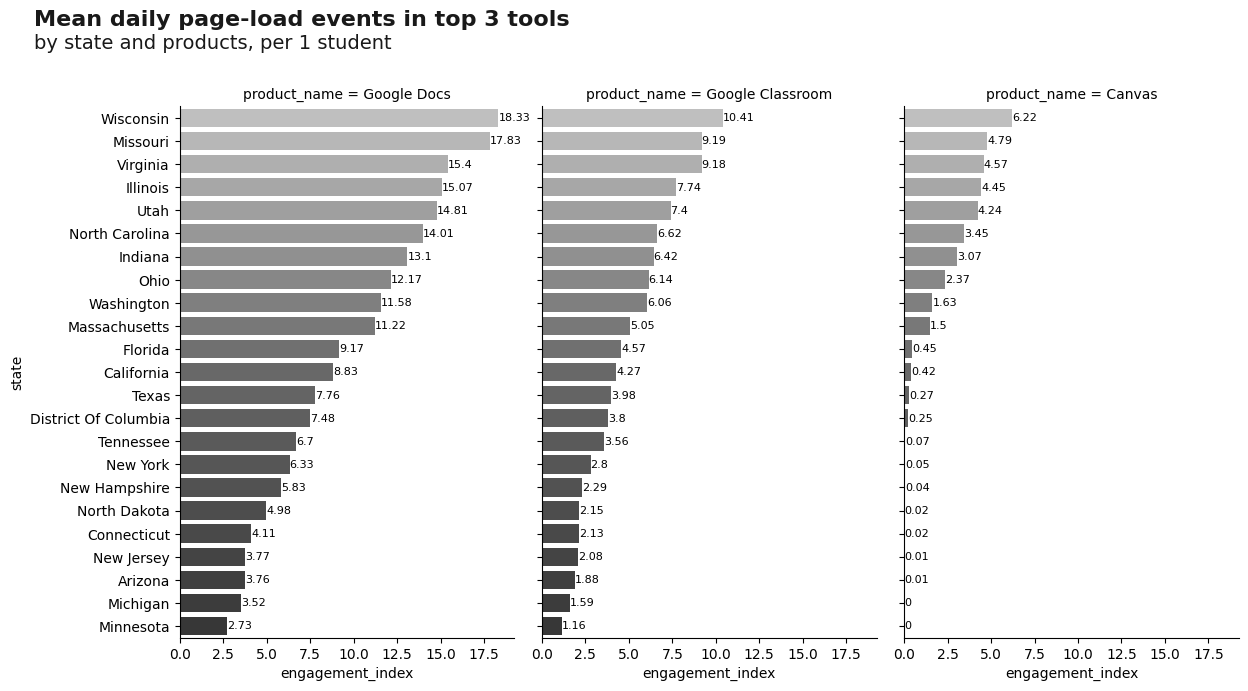

In [13]:
group_02 = (engagement_df_mix.groupby(['state','product_name'])['engagement_index'].mean()/1000)\
            .reset_index().sort_values('engagement_index',ascending = False).fillna(0)

gripo_02_top = group_02.loc[lambda x: x.product_name.isin(g_high)]
gripo_02_top['engagement_index'] = gripo_02_top['engagement_index'].apply(lambda x: round(x,2))
#gripo_02_top = gripo_02_top.loc[lambda x: x['engagement_index']>0]


plt.style.use('default')

g = sns.FacetGrid(gripo_02_top,hue='product_name',col = 'product_name',height=4, col_wrap= 3  )
g.map(sns.barplot, "engagement_index","state", palette="Greys_d",)

g.fig.set_size_inches(15, 8)
g.fig.subplots_adjust(top=0.81, right=0.86)

axes = g.axes.flatten()
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container,fontsize=8)


plt.text(x = -50, y = -4, s = "Mean daily page-load events in top 3 tools",fontsize = 16, weight = 'bold', alpha = .90);
plt.text(x = -50, y = -3, s = "by state and products, per 1 student",fontsize = 14,  alpha = .90);
plt.show()

## Summary
* Depending on what you want to achieve you might want to carefully preselect districts. Note that we approach in this notebook might not necessarily suit your individual purposes.
* When looking at digital learning, you might want to spend sometime in figuring out which districts actually applied digital learning

## References

* [Diverging Color Maps for Scientific Visualization (Expanded) - Kenneth Moreland](https://www.kennethmoreland.com/color-maps/ColorMapsExpanded.pdf)

* [Kaggle Competitions](https://www.kaggle.com/c/learnplatform-covid19-impact-on-digital-learning):
    * [Enthusiast to Data Professional - What changes?](https://www.kaggle.com/spitfire2nd/enthusiast-to-data-professional-what-changes/)
    * [How To Approach Analytics Challenges](https://www.kaggle.com/iamleonie/how-to-approach-analytics-challenges)
    * [Most popular tools in 2020 Digital Learning](https://www.kaggle.com/michau96/most-popular-tools-in-2020-digital-learning)